# TME ML Non supervisé

In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

# K-Means et clustering Géographique

## 1- Data preparation

<div class="alert alert-block alert-info">
Pour cette partie, nous allons reprendre les données des points d'intérêts (POI) de Paris. L'objectif est de caractériser spatialement l'espace urbain parisien en fonction des POIs présents dans une région. Le clustering des régions permet ainsi de mettre en évidence les régions similaires et les raisons de leur similarité (en analysant le prototype de chaque cluster).
    
Les lignes suivantes permettent de dessiner les arrondissements parisien à partir du fichier <code>districts-paris.csv</code> et le charger les POIs (fichier <code>poi-paris.csv`)
</div>

In [34]:
table_poi = pd.read_csv('data/poi-paris.csv')
districts=pd.read_csv('data/districts-paris.csv', sep = ',')
districts['bounds'] = districts['bounds'].apply(eval)
#  Draw the districts
def draw_districts():
    for x in districts['bounds']:
        plt.plot([c[0] for c in x], [c[1] for c in x], color = 'black')

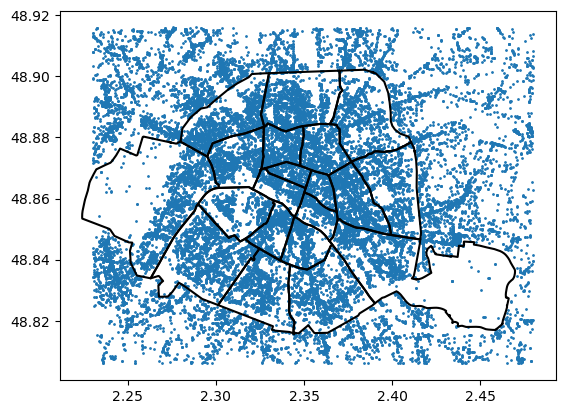

In [26]:
plt.scatter(table_poi["longitude"],table_poi['latitude'],s=1)
draw_districts()

### 2 - Discrétisation manuelle de l'espace

<div class="alert alert-block alert-info">

On ne peut pas utiliser la discrétisation naturelle des arrondissements car celle-ci est trop grande et regroupe des sous-régions de type très différent. Une première façon d'obtenir des sous-régions intéressantes dans Paris est de faire une discrétisation en grille, manuelle. On supposera la grille régulière de taille $N$.

On a donc besoin de connaître pour une coordonnée GPS $(long,lat)$ quelle est la cellule $(i,j)$ de la grille correspondante. Pour une grille de taille $N\times N$, la formule est la suivante : $i=\lfloor N*\frac{(longitude-lomin)}{(lomax-lomin)}\rfloor$ and $j = \lfloor N*\frac{(latitude - lamin)}{(lamax-lamin)} \rfloor$ , avec $\lfloor x\rfloor$ la partie entière de $x$, $lamin,lamax$ les latitudes minimale et maximale, $lomin,lomax$ les longitudes  minimales et maximales.

Chaque cellule de la grille sera décrite par la distribution des types des POIs présents dans l'espace correspondant à la cellule. Il y a 12 types de POIs, ainsi chaque cellule est décrit par un vecteur de dimension 12, donc chaque dimension indique la probabilité du type associé à la dimension dans la région. 
    
Calculez la description associée à chaque cellule. 

Executez un k-means dessus (en utilisant `KMeans` de scikit-learn, `n_clusters` permet de fixer le nombre de cluster, la méthode `fit()` permet de réaliser le clustering, la méthode `predict()` d'obtenir le cluster associé à chaque exemple, la méthode `fit_predict()` de faire les deux en même temps).

Visualisez également les centroïdes des clusters. Faites varier le nombre de clusters et comparez les résultats.

Le code suivant permet de représenter graphiquement le clustering calculé (avec `get_clust(i,j)` renvoyant le numéro du cluster associé à la cellule $(i,j)$) et de tracer les centroïdes (d'un KMeans stocké dans la variable `km`).


In [33]:
table_poi.columns

Index(['name', 'latitude', 'longitude', 'note', 'price', 'furniture_store',
       'laundry', 'bakery', 'cafe', 'home_goods_store', 'clothing_store',
       'atm', 'lodging', 'night_club', 'convenience_store', 'restaurant',
       'bar', 'i', 'j'],
      dtype='object')

In [49]:
# Calculate the bounding box of Paris
from sklearn.cluster import KMeans


lamin, lamax = table_poi['latitude'].min(), table_poi['latitude'].max()
lomin, lomax = table_poi['longitude'].min(), table_poi['longitude'].max()

# Define the size of the grid
N = 50


# Compute the grid coordinates for each POI with a small tolerance
table_poi['i'] = np.floor(N * (table_poi['longitude'] - lomin) / (lomax - lomin )).astype(int) - 1
table_poi['j'] = np.floor(N * (table_poi['latitude'] - lamin) / (lamax - lamin )).astype(int) - 1


# Create an array to store the distribution of POI types for each cell
cell_poi_distribution = np.zeros((N, N, 12))

# Update the distribution array with the POI data
poi_types = ['furniture_store', 'laundry', 'bakery', 'cafe', 'home_goods_store', 'clothing_store',
             'atm', 'lodging', 'night_club', 'convenience_store', 'restaurant', 'bar']
for _, poi in table_poi.iterrows():
    for idx, poi_type in enumerate(poi_types):
        cell_poi_distribution[poi.i, poi.j, idx] += poi[poi_type]

# Normalize the distribution array with a small epsilon value to avoid division by zero
epsilon = 1e-10
cell_poi_distribution /= (cell_poi_distribution.sum(axis=2, keepdims=True) + epsilon)


# Flatten the array for clustering
cell_poi_distribution_flat = cell_poi_distribution.reshape(-1, 12)

# Run K-means clustering
n_clusters = 12
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(cell_poi_distribution_flat)

# Visualization
def get_clust(i, j):
    return labels[i * N + j]



/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


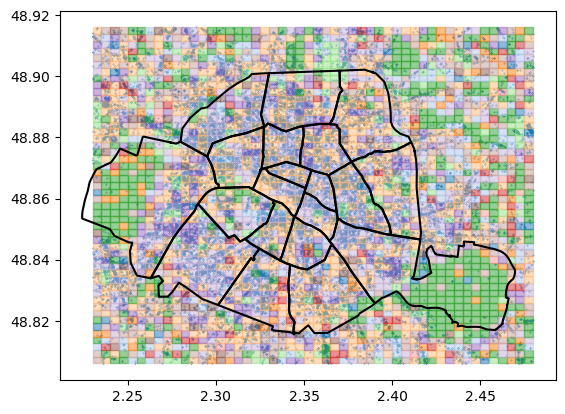

In [50]:
from matplotlib.patches import Rectangle
from matplotlib.cm import tab20


_ = plt.scatter(table_poi["longitude"],table_poi['latitude'],s=0.1)
draw_districts()
for i in range(N):
    for j in range(N):
        x = lomin + (lomax - lomin) * i / N
        y = lamin + (lamax - lamin) * j / N
        c = tab20.colors[get_clust(i,j)]
        _ = plt.gca().add_patch(Rectangle((x, y), (lomax - lomin) / N, (lamax - lamin) / N, color = c, alpha = 0.5))


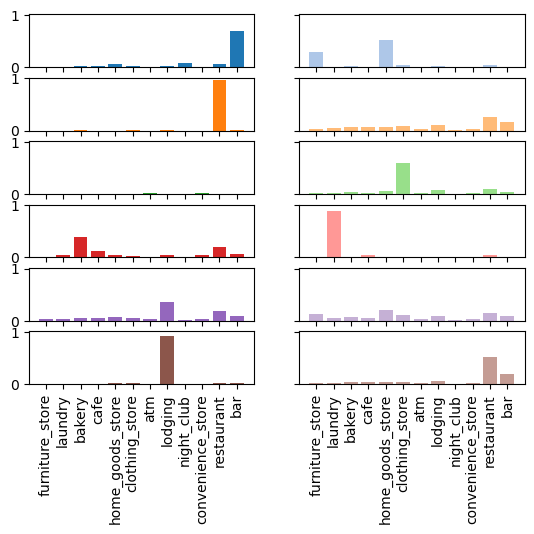

In [51]:
fig, axs = plt.subplots(len(km.cluster_centers_)//2, 2, sharey=True,sharex=True)
for i,k in enumerate(km.cluster_centers_):
    axs.flatten()[i].bar(range(len(k)),k,color=tab20.colors[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(poi_types ,rotation="vertical")

<div class="alert alert-block alert-info">
Le score elbow du  modèle correspond à l'attribut <em>inertia_</em> du modèle. Dessinez la courbe elbow en fonction du nombre de clusters. Quel est le nombre optimal de clusters d'après cette courbe ?
    </div>

## 3 -  K-Means pour la discrétisation automatique de l'espace

<div class="alert alert-block alert-info">
    Pour obtenir des clusters plus pertinents, la discrétisation de l'espace doit être faite de manière moins naïve. Une idée est d'utiliser églament l'algorithme  $K$-means pour cela, en clusterisant les coordonnées GPS des POIs (ce qui est également appelé une <em>quantization</em>). 
    </br>
    Calculez ce clustering spatial et attribuez à chaque POI un numéro de cluster spatial (n.b. une grille de taille $10\times 10$ est "équivalente" à avoir 100 clusters).
    
Représentez graphiquement les clusters ainsi trouvés à l'aide des lignes de codes suivantes (<code>get_cluster_spatial(i)</code> rend le cluster du $i$-ème POI, le modèle KMeans est stocké dans la variable <code>km_spatial</code>).

Effectuez le clustering sur cette nouvelle discrétisation et comparez vos résultats.

Observez la corrélation entre les types sur les données initiales. Pouvez vous proposer un traitement pour améliorer les résultats ?
</div>

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


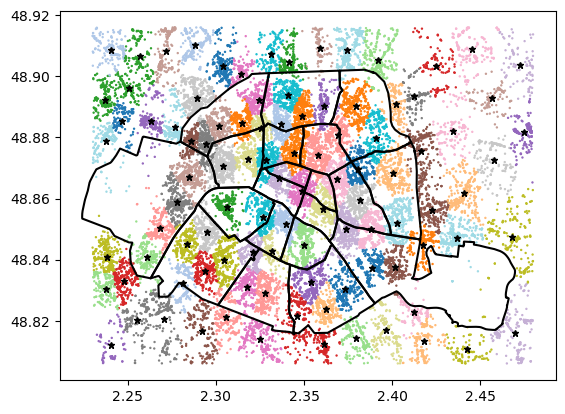

In [53]:
# Step 1: Perform K-means clustering on the latitude and longitude of the POIs
K_GEO = 100
km_spatial = KMeans(n_clusters=K_GEO)
spatial_labels = km_spatial.fit_predict(table_poi[['longitude', 'latitude']])

# Step 2: Assign a spatial cluster number to each POI
table_poi['spatial_cluster'] = spatial_labels

# Step 3: Visualize the found clusters
def get_cluster_spatial(i):
    return table_poi.loc[i, 'spatial_cluster']

draw_districts()
plt.scatter(table_poi['longitude'],table_poi['latitude'],color = [tab20.colors[get_cluster_spatial(i) % 20] for i in range(len(table_poi))], s = 0.5)
for i in range(K_GEO):
    plt.plot(km_spatial.cluster_centers_[i, 0], km_spatial.cluster_centers_[i, 1], marker = "*", color = "black", markersize = 5)

# Réduction de dimension, Visualisation et Segmentation de clients

In [55]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [56]:
data = pd.read_csv("data/customers.csv")

<div class = "alert alert-block alert-info">
Le fichier <code>customers.csv</code> contient une liste de clients avec leur dépense totale par type de produit. L'objectif est de réaliser une segmentation de cette clientèle et d'expérimenter les techniques de réduction de dimension et de visualisation
</div>

## 1 EDA (exploratory data analysis)

<div class = "alert alert-block alert-info">
    On réalise toujours une EDA (analyse exploratoire des données) pour comprendre la distribution des données, remarquer des incohérences et les pré-traitements nécessaires. 
La cellule suivante trace les graphes les plus utilisés dans ce genre d'analyse. 

Que pouvez-vous déduire de ces graphes ? Quelle(s) opération(s) est-il nécessaire de faire sur les données ? Remarquez vous des différences dans la matrice de corrélation après ces transformations ?
</div>

In [57]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


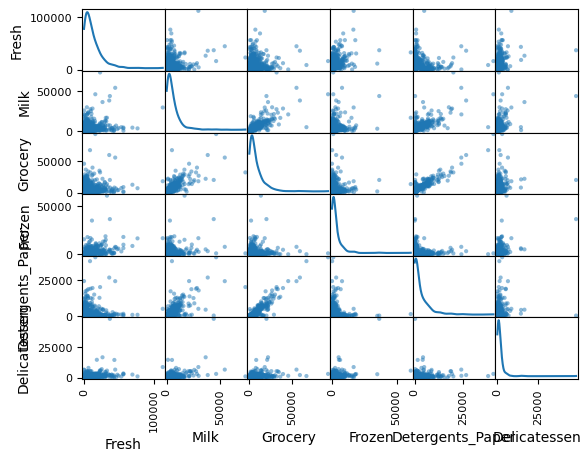

In [58]:
_ = pd.plotting.scatter_matrix(data,diagonal='kde')

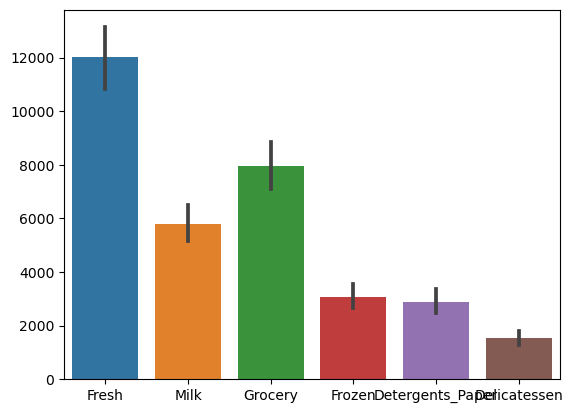

In [59]:

_ = sns.barplot(data=data)

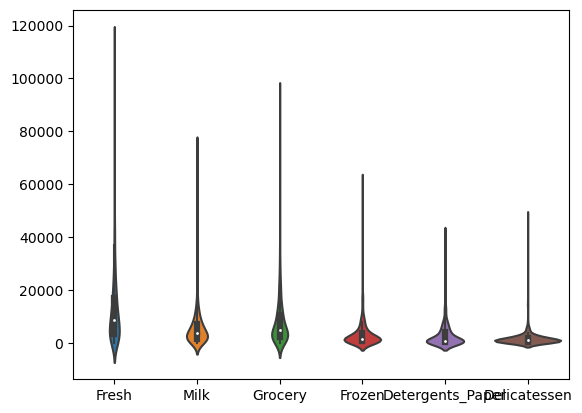

In [60]:
_ = sns.violinplot(data=data)

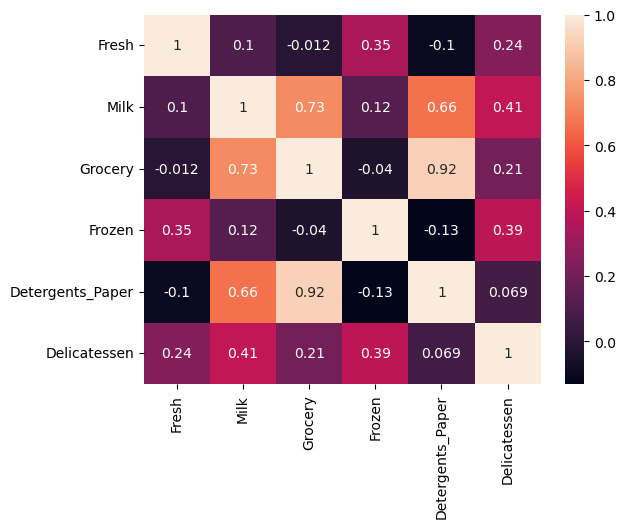

In [61]:
_ = sns.heatmap(data.corr(),annot=True)

# 2 - Réduction de dimension et visualisation
Cette partie est essentiellement plus un tutoriel qu'un TP, qui vous montre les différentes techniques de réduction de dimension et de visualisation. Vous pouvez changer les paramètres et observer les résultats.

<div class = "alert alert-block alert-info">
Les lignes suivantes permettent  d'effectuer une  PCA sur les données normalisées et après une transformation logarithmique.
    
Observez en particulier la variance expliquée par chaque axe de la PCA, la contribution de chaque dimension d'origine aux nouvelles dimensions, le biplot où sont représentés les individus et les anciens axes. Est-ce compatible avec ce que vous avez interprété de la matrice de corrélation ? Avons nous plus d'informations ?
    
On appliquera par la suite les algos de clustering sur la représentation PCA pour analyser la segmentation.
</div>

In [ ]:
from sklearn.decomposition import PCA
tab20 = plt.get_cmap('tab20')
log_data = np.log(data)
log_data[log_data.columns] = preprocessing.StandardScaler().fit_transform(log_data[log_data.columns])
pca = PCA(n_components=5).fit(log_data)
pca_data= pca.transform(log_data)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.components_)
plt.bar(x=range(pca.components_.shape[1]),height=pca.components_[0])

In [ ]:
plt.scatter(pca_data[:,0],pca_data[:,1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,log_data.columns[i])

### K-Means

<div class = "alert alert-block alert-info">
On peut observer la courbe Elbow pour K-Means ainsi que le score silhouette.
 
Il faut faire attention  de retourner dans l'espace d'origine pour tracer les centroïdes.

</div>


In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
km = KMeans(n_clusters=5)


In [ ]:
elbow = []
s_score = []
for i in range(2,20):
    km.n_clusters = i
    p = km.fit_predict(pca_data)
    elbow.append(km.inertia_)
    s_score.append(silhouette_score(pca_data,p))
plt.plot(range(2,20),elbow,"+-")
plt.figure()
plt.plot(range(2,20),s_score,"+-")

In [ ]:
km.n_clusters = 8
pred = km.fit_predict(pca_data)
plt.scatter(pca_data[:,0],pca_data[:,1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)

# Revenir à l'espace d'origine

real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))
fig, axs = plt.subplots(km.n_clusters//2, 2, sharey=True,sharex=True)
for i,k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)),k,color=tab20.colors[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(data.columns,rotation="vertical")

### Clustering agglomératif


In [ ]:
agglo = AgglomerativeClustering()
agglo.fit(pca_data)

In [ ]:
import scipy.cluster.hierarchy as shc
agglo = shc.linkage(pca_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=agglo)
plt.show()

In [ ]:
agglo = AgglomerativeClustering()
s_agglo = []
for i in range(2,20):
    agglo.n_clusters=i
    agglo_lab = agglo.fit_predict(pca_data)
    s_agglo.append(silhouette_score(pca_data,agglo_lab))
plt.plot(range(2,20),s_agglo,"+-")

In [ ]:
agglo.n_clusters=8
agglo_lab = agglo.fit_predict(pca_data)
plt.scatter(pca_data[:,0],pca_data[:,1],color = [tab20.colors[agglo_lab[i]] for i in range(len(pca_data))],s=5)


### DBSCAN

In [ ]:
db = DBSCAN()
db_lab = db.fit_predict(pca_data)
plt.scatter(pca_data[:,0],pca_data[:,1],color = [tab20.colors[db_lab[i]] for i in range(len(pca_data))],s=5)


### Isomap
Pour la coloration, on utilise les résultats du K-Means.

In [ ]:
from sklearn.manifold import Isomap, TSNE, MDS
iso_data = Isomap().fit_transform(pca_data)
plt.scatter(iso_data[:,0],iso_data[:,1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)


### MDS

In [ ]:
mds_data = MDS().fit_transform(pca_data)
plt.scatter(mds_data[:,0],mds_data[:,1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)


### T-SNE

In [ ]:
tsne = TSNE()
tsne.perplexity = 10
tsne_data = tsne.fit_transform(pca_data)

plt.scatter(tsne_data[:,0],tsne_data[:,1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)


In [ ]:
tsne.perplexity = 30
tsne_data = tsne.fit_transform(pca_data)

plt.scatter(tsne_data[:,0],tsne_data[:,1],color = [tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)
